#Assignment 3 (Part I)



Install dependencies

In [ ]:
%rm -rf CarRacingWObstacles
!git clone https://github.com/luisgarrote/CarRacingWObstacles.git




UsageError: Line magic function `%rm` not found.


In [3]:
!pip install swig

  Using cached swig-4.4.0-py3-none-win_amd64.whl.metadata (3.5 kB)
Using cached swig-4.4.0-py3-none-win_amd64.whl (2.5 MB)


In [4]:
%cd CarRacingWObstacles

!pip install -r requirements.txt


[WinError 2] O sistema não conseguiu localizar o ficheiro especificado: 'CarRacingWObstacles'
c:\Users\cedri\Documents\GitHub\CarRacingWObstacles
  Using cached gymnasium-1.2.3-py3-none-any.whl.metadata (10 kB)
  Using cached cloudpickle-3.1.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ----- ---------------------------------- 1.6/10.6 MB 9.4 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/10.6 MB 10.7 MB/s eta 0:00:01
   --------------------------- ------------ 7.3/10.6 MB 12.6 MB/s eta 0:00:01
   ----------------------------------- ---- 9.4/10.6 MB 12.0 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 11.8 MB/s  0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 16.6 MB/s  0:00:00
Using cached gymnasium-1.2.3-py3-none-any

Imports

In [5]:
pip install -e .


Obtaining file:///C:/Users/cedri/Documents/GitHub/CarRacingWObstacles
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for car_racing_obstacles
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Legacy editable install of car_racing_obstacles==0.1.0 from file:///C:/Users/cedri/Documents/GitHub/CarRacingWObstacles (setup.py develop) is deprecated. pip 25.3 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure

import gymnasium as gym
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random
from gymnasium import wrappers
import copy
from gymnasium.wrappers import RecordVideo

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from car_racing_obstacles import CarRacingObstacles
gym.register(
    id="CarRacingObstacles-v3",
    entry_point="car_racing_obstacles:CarRacingObstacles",
)

print(device)


cuda:0


Deep RL Replay Buffer

In [2]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size
        self.counter = 0
        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []
        self.new_state_buffer = []
        self.terminal_buffer = []

    def store_tuples(self, state, action, reward, new_state, done):
        if len(self.state_buffer) < self.size:
            self.state_buffer.append(None)
            self.action_buffer.append(None)
            self.reward_buffer.append(None)
            self.new_state_buffer.append(None)
            self.terminal_buffer.append(None)

        self.counter = self.counter % self.size
        self.state_buffer[self.counter] = state
        self.action_buffer[self.counter] = action
        self.reward_buffer[self.counter] = reward
        self.new_state_buffer[self.counter] = new_state
        self.terminal_buffer[self.counter] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch=[];
        action_batch=[];
        reward_batch=[];
        new_state_batch=[];
        done_batch=[];

        for a in batch:
            state_batch.append(self.state_buffer[a])
            action_batch.append(self.action_buffer[a])
            reward_batch.append(self.reward_buffer[a])
            new_state_batch.append(self.new_state_buffer[a])
            done_batch.append(self.terminal_buffer[a])
        return state_batch, action_batch, reward_batch, new_state_batch, done_batch





Default DQN arquitecture

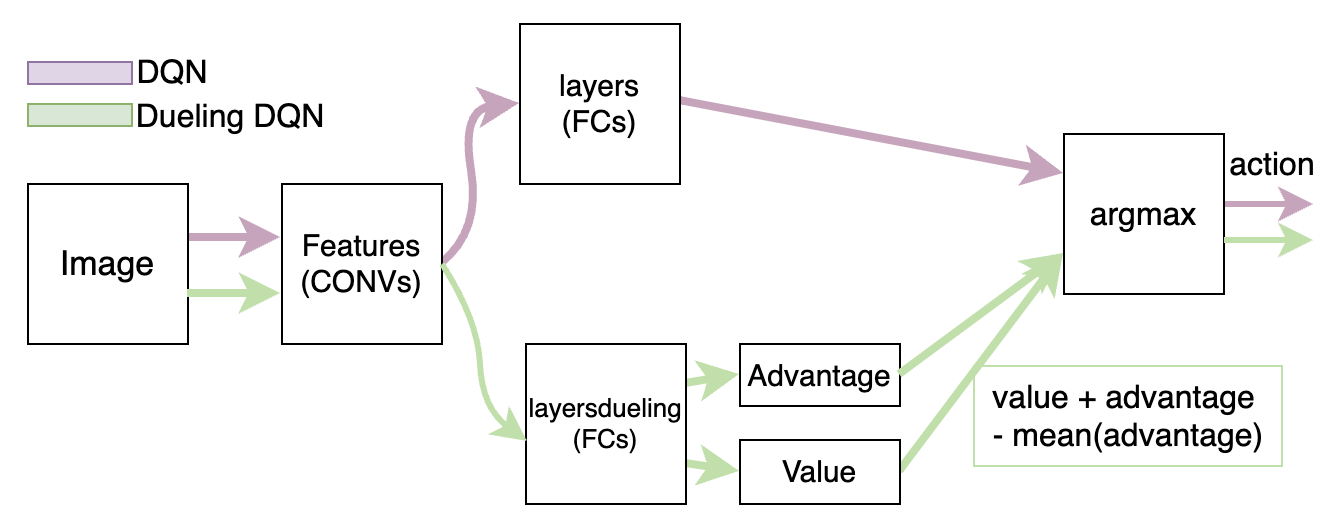

## CNN 1

In [44]:
from torchvision import datasets, models
class DQN(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()

        self.input_size=inputs;
        self.output_size=outputs;


        self.features = nn.Sequential(
                                   #Add code here for DQN
                                   #you can use the same code for dueling
            nn.Conv2d(inputs, 6, 7,stride=3, padding=1),  # Conv1
            nn.ReLU(True),
            nn.MaxPool2d(2,2),  # Conv1
            nn.Conv2d(6, 12, 4, padding=1),  # Conv1
            nn.ReLU(True),
            nn.MaxPool2d(2,2),  # Conv1
        )

        self.layers = nn.Sequential(nn.Linear(588, 128),
            nn.ReLU(),
            nn.Linear(128, outputs)
        )


        self.layersdueling = nn.Sequential(
            nn.Linear( 588, 128),
            nn.ReLU()
        )


        self.advantage = nn.Sequential(
            nn.Linear(128, outputs)
        )

        self.value = nn.Sequential(
            nn.Linear(128, 1)
        )

###### DQN/Double DQN configuration

###########    ############    #################
#         #    #          #    #               #
#   IMG   # -> # features # -> #     layers    #    .... argmax ....
#         #    #  (CONVs) #    #     (FCs)     #
###########    ############    #################


###### Dueling configuration
                                                    #############
###########    ############    #################    # advantage #
#         #    #          #    #               # -> #############   ... value + advantage  - advantage.mean() ... argmax ...
#   IMG   # -> # features # -> # layersdueling # -> #############
#         #    #  (CONVs) #    #     (FCs)     #    #   value   #
###########    ############    #################    #############





    def forward(self, x):  # primeiras alteracoes para ter QN


        x = self.features(x) # normal para passar pelas conv layers

        x = x.view(x.size(0), -1) # dar flat para as conv layers

        if useDueling: # DQN ou Dueling 
            x = self.layersdueling(x)
            advantage = self.advantage(x)
            value = self.value(x)
            return value + advantage - advantage.mean(dim=1, keepdim=True) # Q(s,a) = V(s) + (A(s,a) - mean(A(s,a))) formula enunciado
        
        else:
            x = self.layers(x)
            return x






    def policy(self,state):
       with torch.no_grad():
            return self.__call__(state.unsqueeze(0)).argmax()

    def getPolicy(self,state,eps_threshold):
        sample = random.random()
        if sample > eps_threshold:
            with torch.no_grad():
                return self.__call__(state.unsqueeze(0)).argmax()
        else:
            return  torch.tensor(random.randrange(self.output_size), device=device, dtype=torch.long)


## CNN 2

In [25]:
from torchvision import datasets, models
class DQN(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()

        self.input_size=inputs;
        self.output_size=outputs;


        self.features = nn.Sequential(

            nn.Conv2d(inputs, 16, 7, stride=3, padding=1),  # Conv1
            nn.ReLU(True),
            nn.MaxPool2d(2,2),  # Conv1
            nn.Conv2d(16, 32, 4, padding=1),  # Conv1
            nn.ReLU(True),
            nn.MaxPool2d(2,2),  # Conv1
        )

        self.layers = nn.Sequential(nn.Linear(1568, 256),
            nn.ReLU(),
            nn.Linear(256, outputs)
        )


        self.layersdueling = nn.Sequential(
            nn.Linear( 1568, 256),
            nn.ReLU()
        )


        self.advantage = nn.Sequential(
            nn.Linear(256, outputs)
        )

        self.value = nn.Sequential(
            nn.Linear(256, 1)
        )

###### DQN/Double DQN configuration

###########    ############    #################
#         #    #          #    #               #
#   IMG   # -> # features # -> #     layers    #    .... argmax ....
#         #    #  (CONVs) #    #     (FCs)     #
###########    ############    #################


###### Dueling configuration
                                                    #############
###########    ############    #################    # advantage #
#         #    #          #    #               # -> #############   ... value + advantage  - advantage.mean() ... argmax ...
#   IMG   # -> # features # -> # layersdueling # -> #############
#         #    #  (CONVs) #    #     (FCs)     #    #   value   #
###########    ############    #################    #############





    def forward(self, x):  # primeiras alteracoes para ter QN


        x = self.features(x) # normal para passar pelas conv layers

        x = x.view(x.size(0), -1) # dar flat para as conv layers

        if useDueling: # DQN ou Dueling 
            x = self.layersdueling(x)
            advantage = self.advantage(x)
            value = self.value(x)
            return value + advantage - advantage.mean(dim=1, keepdim=True) # Q(s,a) = V(s) + (A(s,a) - mean(A(s,a))) formula enunciado
        
        else:
            x = self.layers(x)
            return x






    def policy(self,state):
       with torch.no_grad():
            return self.__call__(state.unsqueeze(0)).argmax()

    def getPolicy(self,state,eps_threshold):
        sample = random.random()
        if sample > eps_threshold:
            with torch.no_grad():
                return self.__call__(state.unsqueeze(0)).argmax()
        else:
            return  torch.tensor(random.randrange(self.output_size), device=device, dtype=torch.long)


## CNN 3

In [8]:
from torchvision import datasets, models
class DQN(nn.Module):

    def __init__(self, inputs, outputs, H=96, W=96):
        super(DQN, self).__init__()

        self.input_size=inputs;
        self.output_size=outputs;


        self.features = nn.Sequential(

            nn.Conv2d(inputs, 32, kernel_size=8, stride=4), # Conv1
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, inputs, H, W)
            n_flat = self.features(dummy).view(1, -1).size(1)


        self.fc = nn.Sequential(
            nn.Linear(n_flat, 512),
            nn.ReLU()
        )


        self.advantage = nn.Linear(512, outputs)
        

        self.value = nn.Linear(512, 1)
        

###### DQN/Double DQN configuration

###########    ############    #################
#         #    #          #    #               #
#   IMG   # -> # features # -> #     layers    #    .... argmax ....
#         #    #  (CONVs) #    #     (FCs)     #
###########    ############    #################


###### Dueling configuration
                                                    #############
###########    ############    #################    # advantage #
#         #    #          #    #               # -> #############   ... value + advantage  - advantage.mean() ... argmax ...
#   IMG   # -> # features # -> # layersdueling # -> #############
#         #    #  (CONVs) #    #     (FCs)     #    #   value   #
###########    ############    #################    #############





    def forward(self, x):  # primeiras alteracoes para ter QN


        x = self.features(x) # normal para passar pelas conv layers

        x = x.view(x.size(0), -1) # dar flat para as conv layers

        x = self.fc(x)

        if useDueling: # DQN ou Dueling 
            advantage = self.advantage(x)
            value = self.value(x)
            return value + advantage - advantage.mean(dim=1, keepdim=True) # Q(s,a) = V(s) + (A(s,a) - mean(A(s,a))) formula enunciado
        
        else:
            x = self.advantage(x)
            return x




    def policy(self,state):
       with torch.no_grad():
            return self.__call__(state.unsqueeze(0)).argmax()

    def getPolicy(self,state,eps_threshold):
        sample = random.random()
        if sample > eps_threshold:
            with torch.no_grad():
                return self.__call__(state.unsqueeze(0)).argmax()
        else:
            return  torch.tensor(random.randrange(self.output_size), device=device, dtype=torch.long)


In [27]:
from IPython.display import HTML
HTML('<iframe width="1297" height="865" src="https://www.youtube.com/embed/kXXdMlyP4OE" title="APA2025 - CarRacingObstacles-v3" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>')



c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\IPython\core\display.py:447: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


OpenAI Environment CarRacing-v2
[Sample result](https://youtu.be/kXXdMlyP4OE)

###    Description:
        Continuous or discrete control task to learn from pixels, a top-down racing environment.
###    Observation:
        Type: Image (96x96x3)
        Some indicators are shown at the bottom of the window along with the state RGB buffer. From left to right: the true speed, four ABS sensors, the steering wheel position and gyroscope.
###    Actions:
        Discrete Mode: 'nothing','left','right','gas','brake'
        Continuous Mode: 3 different variables can be modified: steering wheel, gas, and brake. For the methods explored in this Colab, discrete control commands are reasonable (a set of control commands is provided for this mode).
###    Reward:
        The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.
###    Starting State:
        The tracks and colors are randomly generated with UseRandomize=True for each episode. With UseRandomize=False, only the tracks are random.
###    Episode Termination:
        Car is too faraway from the track.
        Car accumulated a negative reward after given iterations (see ResetCounter and InitCounter).
        Episode length is greater than 1000.
        All tiles are visited.
###     Solved Requirements:
        The game is solved when the agent consistently gets 900+ points. For this assignment a minimum of 200 points are required.


DQN movie generation (for visual evaluation in Google Colab)

In [26]:

def createMovie(Network,Filename,UseRandomizer,UseContinuous):

    env1 = gym.make("CarRacingObstacles-v3", render_mode="rgb_array",domain_randomize=UseRandomizer, continuous=UseContinuous)
    envX = env1
    envX = RecordVideo(env1, video_folder='./videos/'+Filename,  episode_trigger = lambda x: True)

    new_state = envX.reset(options={"randomize": UseRandomizer})


    stackedStateX=[np.rollaxis(new_state[0], 2, 0).copy() for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96)) ).float().to(device)


    i=0
    Network.eval()
    resetStatus=0;


    while True:
        envX.render()

        action = Network.policy(state);
        reward=0
        for x in range(ControlSteps):
            new_state, r, done, truncated, _  = envX.step(action_space[action.item()])
            reward+=r
            if(done or truncated):
                break
        stackedStateX.pop(0)


        stackedStateX.append(np.rollaxis(new_state, 2, 0).copy())
        state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96))).float().to(device)
        i=i+1;
        if done or truncated:
          break;

    envX.close()
    env1.close();
    Network.train()
    mp4list = glob.glob('./videos/'+Filename+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

Dummy Net with random policy

In [47]:
class RandomNet(nn.Module):

    def __init__(self,outputs):
        super(RandomNet, self).__init__()
        self.output_size=outputs;


    def forward(self, x):
        return  x

    def policy(self,state):
       return  torch.tensor([[random.randrange(self.output_size)]], device=device, dtype=torch.long)



Parameters

In [36]:



###################################################
###################################################
###################################################
UseRandomize=False; # default é false, testar a true com o melhor modelo
UseContinuousControl=True; # ALTERAR !! Primeiro foi testado com True, agora com false TRUE conseguiu melhores resultados
###################################################
###################################################
###################################################


if UseContinuousControl:
    #action space is still discretized however more actions can be selected
    action_space    = [
            np.array([-1, 1, 0.2]), np.array([0, 1, 0.2]), np.array([1, 1, 0.2]), #           Action Space Structure
            np.array([-1, 1,   0]), np.array([0, 1,   0]), np.array([1, 1,   0]), #        (Steering Wheel, Gas, Break)
            np.array([-1, 0, 0.2]), np.array([0, 0, 0.2]), np.array([1, 0, 0.2]), # Range        -1~1       0~1   0~1
            np.array([-1, 0,   0]), np.array([0, 0,   0]), np.array([1, 0,   0]) ];


else:
    action_space=[0,1,2,3,4]    #  nothing','left','right','gas','brake'

n_actions=len(action_space)

#hyper-parameters
TotalEpisodes=1000;
MaxSteps=1000;
ControlSteps=3; # number of iterations the same action is executed in the environment
FrameStack=1 # number of consecutive frames used to represent the state
FreezeCounter=50; # clone the model every X episodes
BatchSize=64; # testar com 128 !!
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.995  # default era 0.985
discount_factor=0.99 # valor a alterar para tentar obter melhores resultados, default era 0.95
LearningRate=0.0001 # valor default .0001 (^-4)

SaveAtCounter=50 # save model or video at every X episodes
ResetCounter=30 # maximum number of experiences with bad performance (max=InitCounter+ResetCounter)
InitCounter=30 # minimum number of experiences per episode
FrameSize=3; # 3 if RGB 1 if grayscale

BufferSize=20000  # max number of experiences in the buffer (may need to be smaller if CUDA memory errors occur).


# use these flags to enable Double DQN and Duelinng (Dueling DQN or Double Dueling DQN)
usedoubleDQN=True
useDueling=True



Run the new netwwork with random policy

In [18]:
pip install moviepy

   ---------------------------------------- 0.0/31.2 MB ? eta -:--:--
   --- ------------------------------------ 2.9/31.2 MB 14.0 MB/s eta 0:00:03
   ------- -------------------------------- 5.8/31.2 MB 14.1 MB/s eta 0:00:02
   --------- ------------------------------ 7.1/31.2 MB 11.2 MB/s eta 0:00:03
   ------------ --------------------------- 9.4/31.2 MB 11.5 MB/s eta 0:00:02
   ---------------- ----------------------- 13.1/31.2 MB 12.5 MB/s eta 0:00:02
   -------------------- ------------------- 16.3/31.2 MB 13.0 MB/s eta 0:00:02
   ------------------------- -------------- 19.7/31.2 MB 13.5 MB/s eta 0:00:01
   ----------------------------- ---------- 23.3/31.2 MB 14.1 MB/s eta 0:00:01
   --------------------------------- ------ 26.2/31.2 MB 14.0 MB/s eta 0:00:01
   ------------------------------------- -- 29.6/31.2 MB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 31.2/31.2 MB 14.1 MB/s  0:00:02

   -------- ------------------------------- 1/5 [imageio_ffmpeg]
  

In [19]:
randomnet=RandomNet(n_actions)
createMovie(randomnet,"random",UseRandomize,UseContinuousControl)

c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\random folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Initialization and Parameters:


In [37]:
env = gym.make("CarRacingObstacles-v3", render_mode="rgb_array",domain_randomize=UseRandomize, continuous=UseContinuousControl)
spec = gym.spec("CarRacingObstacles-v3")


#network DQN
policy_net = DQN(FrameSize*FrameStack, n_actions).to(device)
target_net = DQN(FrameSize*FrameStack, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

buffer = ReplayBuffer(BufferSize);

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)
loss=  torch.nn.SmoothL1Loss()

DQN training

In [38]:
def trainModel(buffer_data):
    if buffer_data.counter < BatchSize:
        return 0.0

    state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer_data.sample_buffer(BatchSize)
    state_batch = torch.stack(state_batch).to(device)
    action_batch = torch.stack(action_batch).reshape(-1,1).to(device)
    new_state_batch = torch.stack(new_state_batch).to(device)
    reward_batch = torch.stack(reward_batch).reshape(-1,1).to(device)
    done_batch = torch.stack(done_batch).reshape(-1,1).to(device)


    q_values = policy_net(state_batch)
    q_values = q_values.gather(1, action_batch)


    with torch.no_grad(): 
        if usedoubleDQN: # utilizar double DQN
            next_actions = policy_net(new_state_batch).argmax(dim=1, keepdim=True) # policy_net escolhe a melhor acao para o proximo state
            next_q_values = target_net(new_state_batch).gather(1, next_actions) # target_net calcula o valor para essa acao
        
        else: # utilizar DQN normal
            next_q_values = target_net(new_state_batch).max(1)[0].unsqueeze(1)


    expected_q_values = reward_batch + (discount_factor * next_q_values * (1 - done_batch))
    loss_val = loss(q_values, expected_q_values)

    optimizer.zero_grad()
    loss_val.backward()

    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0) # estabilizar gradientes

    optimizer.step()

    return loss_val.item()

DeepRL Loop

In [39]:
loss_val,scores, episodes,events, avg_scores,avg_scores20,exploration = [],[],[], [],[], [], []

bestScore=-99999;
at=0;


for f in range(TotalEpisodes):
    done  = False
    score = 0.0
    tloss = 0.0

    new_state,_=env.reset(options={"randomize": UseRandomize})#,seed=6)


    stackedState=[np.rollaxis(new_state, 2, 0).copy() for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedState),(FrameSize*FrameStack,96,96)) ).float().to(device)

    if f % FreezeCounter == 0:
       print("########################################"+str(f)+" of "+str(TotalEpisodes))
       target_net.load_state_dict(policy_net.state_dict())

    if f % SaveAtCounter == 0:
      #torch.save(policy_net.state_dict(), "v2CarRacing_"+str(f)+'_model.ckpt')
       createMovie(policy_net,"CarRacing_"+str(f),UseRandomize,UseContinuousControl)

    resetStatus=0;
    i=0

    for F in range(MaxSteps):
        #env.render()
        action = policy_net.getPolicy(state,exploration_threshold)
        reward=0
        for _ in range(ControlSteps):
            new_state, r, done,trunc, info = env.step(action_space[action.item()])
            reward+=r
            i=i+1
            if(done or trunc):
                break
        if reward<0 and i>InitCounter:
            resetStatus=resetStatus+1;
        else:
            resetStatus=0

        stackedState.pop(0)
        stackedState.append(np.rollaxis(new_state, 2, 0).copy())
        new_state=torch.from_numpy(np.reshape(np.array(stackedState),(FrameSize*FrameStack,96,96))).float().to(device)

        score += reward
        if(F<(MaxSteps-1)):
            buffer.store_tuples(state, action, torch.tensor(reward), new_state, torch.tensor(int(done)))

        state = new_state
        trainModel(buffer)


        if(done or trunc or resetStatus>=ResetCounter):
            break
    exploration_threshold= exploration_threshold*exploration_decay if exploration_threshold > exploration_threshold_min else exploration_threshold_min

    if(score>bestScore):
        print("Best EP: ",score," It: ",F*ControlSteps)
        bestScore=score;
        torch.save(policy_net.state_dict(), "BestCarRacing_best_model.ckpt")
        at=f;

    exploration.append(exploration_threshold)
    scores.append(score)
    episodes.append(f)
    events.append(F)
    avg_scores.append(score/F)
    avg_scores20.append(np.mean(scores[-20:]))


policy_net.load_state_dict(torch.load("BestCarRacing_best_model.ckpt", weights_only=True))


########################################0 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_0 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Best EP:  80.92121212121168  It:  345
Best EP:  133.41143911439212  It:  423
########################################50 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_50 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


########################################100 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_100 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Best EP:  143.13533834586573  It:  309
########################################150 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_150 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


########################################200 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_200 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Best EP:  166.27088122605457  It:  540
########################################250 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_250 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


########################################300 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_300 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Best EP:  184.87617328520008  It:  492
Best EP:  249.44801444043622  It:  627
Best EP:  278.61666666667156  It:  837
########################################350 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_350 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Best EP:  334.1028985507239  It:  654
Best EP:  450.17377049179856  It:  975
Best EP:  478.19999999999334  It:  873
Best EP:  623.7400749063555  It:  999
########################################400 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_400 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Best EP:  693.213780918716  It:  999
Best EP:  786.4999999999803  It:  999
Best EP:  826.3114503816648  It:  999
Best EP:  846.9585365853516  It:  999
########################################450 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_450 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Best EP:  883.1358974358811  It:  999
Best EP:  973.4081967212902  It:  999
########################################500 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_500 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Best EP:  1065.9966101694706  It:  999
Best EP:  1131.204347826071  It:  999
Best EP:  1271.0777777777723  It:  999
########################################550 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_550 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


########################################600 of 1000


c:\Users\cedri\anaconda3\envs\pytorch_env\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\cedri\Documents\GitHub\CarRacingWObstacles\videos\CarRacing_600 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


KeyboardInterrupt: 

Plot performance

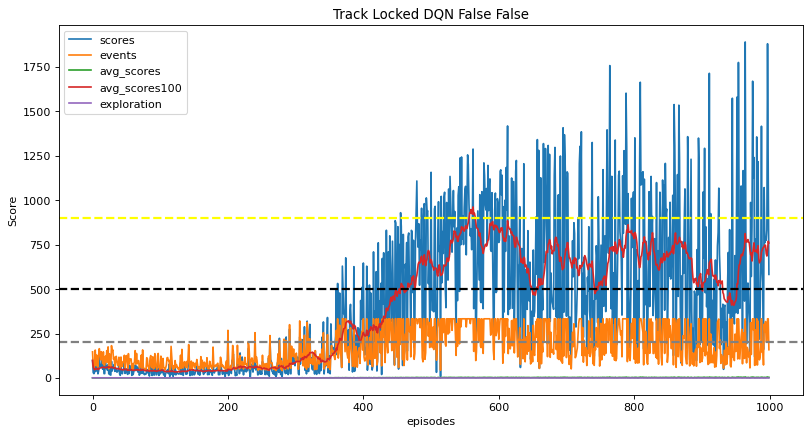

In [31]:
figure(figsize=(12, 6), dpi=80)
plt.plot(episodes, scores)
plt.plot(episodes, events)
plt.plot(episodes, avg_scores)
plt.plot(episodes, avg_scores20)
plt.plot(episodes, exploration)


plt.axhline(y=900, color='yellow', linestyle='--', linewidth=2)
plt.axhline(y=200, color='grey', linestyle='--', linewidth=2)
plt.axhline(y=500, color='black', linestyle='--', linewidth=2)

plt.xlabel('episodes')
plt.ylabel('Score')

plt.title('Track Locked DQN '+str(usedoubleDQN)+' '+str(useDueling))
plt.legend(['scores', 'events', 'avg_scores', 'avg_scores100','exploration'])
plt.show()

View Best Results

In [35]:
policy_net.eval()

createMovie(policy_net,'bestNet',UseRandomize,UseContinuousControl)




In [33]:
def evaluate(Network,UseRandomizer,UseContinuous,seedTest):

    env1 = gym.make("CarRacingObstacles-v3", render_mode="rgb_array",domain_randomize=UseRandomizer, continuous=UseContinuous)
    envX = env1

    new_state = envX.reset(options={"randomize": UseRandomizer},seed=seedTest)#,seed=6)
    new_state, _ = envX.reset(options={"randomize": UseRandomizer},seed=seedTest)#,seed=6)


    stackedStateX=[np.rollaxis(new_state, 2, 0).copy() for i in range(FrameStack)];
    state =torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96)) ).float().to(device)


    i=0
    Network.eval()
    resetStatus=0;

    totalreward=0
    while True:
        action = Network.policy(state);
        reward=0
        for x in range(ControlSteps):
            new_state, r, done, truncated, _  = envX.step(action_space[action.item()])
            reward+=r
            if(done):
                break

        totalreward+=reward;
        stackedStateX.pop(0)

        stackedStateX.append(np.rollaxis(new_state, 2, 0).copy())
        state=torch.from_numpy(np.reshape(np.array(stackedStateX),(FrameSize*FrameStack,96,96))).float().to(device)
        i=i+1;
        if done or truncated:
          break;

    envX.close()
    return totalreward;

In [34]:
print("Total Reward: ",evaluate(policy_net,False,UseContinuousControl,1))
print("Total Reward: ",evaluate(policy_net,False,UseContinuousControl,2))
print("Total Reward: ",evaluate(policy_net,False,UseContinuousControl,3))
print("Total Reward: ",evaluate(policy_net,False,UseContinuousControl,4))
print("Total Reward: ",evaluate(policy_net,False,UseContinuousControl,5))
print("Total Reward: ",evaluate(policy_net,True,UseContinuousControl,6))
print("Total Reward: ",evaluate(policy_net,True,UseContinuousControl,7))
print("Total Reward: ",evaluate(policy_net,True,UseContinuousControl,8))
print("Total Reward: ",evaluate(policy_net,True,UseContinuousControl,9))
print("Total Reward: ",evaluate(policy_net,True,UseContinuousControl,10))


Total Reward:  1648.1454545454746
Total Reward:  270.51373134327827
Total Reward:  1820.1583025830596
Total Reward:  1617.2545454545768
Total Reward:  961.8024316109226
Total Reward:  -50.28848874598085
Total Reward:  -37.237918215613675
Total Reward:  -30.30756756756806
Total Reward:  264.39725490195514
Total Reward:  63.77576642335904
